### Portfolio of Oil Exploration Assets: Learning Options, Sequential Drilling Options and Defer Options 
####  Marco Antonio Guimarães Dias, 
#### Luigi de Magalhães Detomi Calvette
##### RO Congress - Boston 2017


[Paper](http://www.realoptions.org/openconf2017/data/papers/57.pdf)

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy as sci
from scipy.stats import norm
import time
import winsound

In [4]:

duration = 1000  # milliseconds
freq = 440  # Hz

In [5]:
#Importar Case 
case=pd.read_csv("Case_Guy_Head.csv", sep=';')
case.set_index('Type', inplace=True)
case=case.astype(float).T
case

Type,Head
CF,0.20
I_w,80.00
q,0.15
B,500.00
Owner,1.00


In [121]:
###Dados de Entrada###
r=0.03
delta=0.038
sigma=0.3
tau=3
P=50
rho=0.5
CF=case.iloc[0,0]
#q=case.iloc[2,0]
q=0.18
#B=case.iloc[3,0]
B=950
Iw=case.iloc[1,0]
Id=B*5.35 + 650

In [125]:
####Inserindo o DogFish
CF1=0.3
q1=0.2
#B=case.iloc[3,0]
B1=620
Iw1=80
Id1=B1*5.35 + 650

In [149]:
def sinal(CF,CF1,rho):
    
    CF_ins=CF -rho*np.sqrt((CF1 - CF1**2)*(CF-CF**2))/(1-CF1)
    CF_s=CF +rho*np.sqrt((CF1 - CF1**2)*(CF-CF**2))/CF1
    
    return CF_ins,CF_s


In [89]:
def carteira(CF,q,P,B,delta,Id,Iw,r):
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*5.35 + 650)*P/50
    VPL=P*q*B*np.exp(-2*delta) - Id*np.exp(-2*r)
    #c=0.047*P+3
    #VPL=P*case.iloc[2,0]*case.iloc[3,0] - (case.iloc[3,0]*c + 650)
    
    vme=CF*VPL - Iw
    #vme=np.maximum(0,vme)
    ### retorna   VME, Valor, Investimento, (valor - FC*Id), Id+Iw
    return vme, CF*VPL, Iw, CF*P*q*B,CF*Id*np.exp(-2*r) +Iw 

In [126]:
carteira(CF,q,P,B,delta,Id,Iw,r)

(425.1226754622025,
 505.1226754622025,
 80.0,
 1709.9999999999998,
 1159.7330377543412)

In [129]:
carteira(CF1,q1,P,B1,delta,Id1,Iw1,r)

(523.0841727818366, 603.0841727818366, 80, 1860.0, 1200.7939714186143)

In [91]:
#####Valor Beta e Valor Crítico####
def vcritico(I,r,div,sigma,tau):
    if tau <=0:
        vcrit=I
        beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/(sigma**2)) - 0.5,2) +((2*r)/(sigma**2)))
    else:
        if div<=0:
            print("Faça um BSM")
        else:
            
            beta= 0.5 -(r-div)/(sigma**2) + np.sqrt(np.power(((r-div)/sigma**2) -0.5,2) +((2*r)/(sigma**2)))
            V_perp= I*(beta/(beta-1))
            V_0=np.maximum(I, (r/div)*I)
            ht= -1*((r-div)*tau + 2*sigma*np.sqrt(tau))*(V_0/(V_perp - V_0))
            vcrit= V_0 + (V_perp - V_0)*(1- np.exp(ht))
    return[beta,vcrit, V_perp]
            
        
        

In [92]:
####Método Black Merton e Scholes
def bsm(V,I,r,div,sigma,tau):
    #Opção de Compra Europeia com dividendos - Merton
    

    if tau <=0:
        call=np.maximum(V-I,0)
        put=np.maximum(I-V,0)
    else:
        h1=(np.log(V/I) + ((r-div) +(0.5*np.power(sigma,2)))*tau)/(sigma*np.sqrt(tau))
        h2=h1 -sigma*np.sqrt(tau)
        
        call= V*np.exp(-div*tau)*norm.cdf(h1) -I*np.exp(-r*tau)*norm.cdf(h2)
        put= call + (np.exp(-r*tau)*I - V*np.exp(-div*tau))
        put2= I*np.exp(-r*tau)*(1- norm.cdf(h2)) - V*np.exp(-div*tau)*(1-norm.cdf(h1))
    #return[call, put, norm.cdf(h1), norm.cdf(h2),put2]
    return[call, put]





In [93]:
###Função probabilidade para cálculo do gatilho pelo método de aproximação analítica
def prob(V,tau,gama,h,vcrit,r,div,sigma):
    ####Função probabilidade
    lamba=(-r +(gama*(r-div)) +0.5*gama*(gama-1)*sigma**2)*tau
    dist= -(np.log(V/h)+((r-div)+(gama - 0.5)*sigma**2)*tau)/(sigma*np.sqrt(tau))
    kappa= (2*gama -1) +  2*(r-div)/(sigma**2)
    prob=np.exp(lamba)*(V**gama)*(norm.cdf(dist) - ((vcrit/V)**kappa)*(norm.cdf(dist -(2*np.log(vcrit/V))/(sigma*np.sqrt(tau)))))
    
    return[prob]
    

In [94]:
### Método Bjerksund e Stensland (1993) - saida - Derivativo, Gatilho e V_0
def bjst(V,I,r,div,sigma,tau):
    #### Call americana
    if div <=0: #igual a call europeia
        bs=bsm(V,I,r,div,sigma,tau)[0]
    else:
        beta=vcritico(I,r,div,sigma,tau)[0]
        vcrit=vcritico(I,r,div,sigma,tau)[1]
        alpha= (vcrit - I)*vcrit**(-beta)
        
        if V>= vcrit:
            bs=V-I
        else:
            bs= alpha*V**beta -alpha*prob(V,tau,beta,vcrit,vcrit,r,div,sigma)[0]+prob(V,tau,1,vcrit,vcrit,r,div,sigma)[0]-prob(V,tau,1,I,vcrit,r,div,sigma)[0]-I*prob(V,tau,0,vcrit,vcrit,r,div,sigma)[0]+I*prob(V,tau,0,I,vcrit,r,div,sigma)[0]
    
    return[bs, vcrit, V]
    
    

In [95]:
##################################################3
#####################################################
###########Solucao e_ DF ##############


In [96]:
def diffinexpcart(P,I,r,div,sigma,tau,accur):
    #############################################################
    #######Método por diferenças finitas explícitas##############
    #accur=0.05  #Porcentagem de acurácia
    
    #####Solução por diferenças finita explícitas###
    #Precisão em e intervalo da célula em V
    deltaP=P*accur
    
    # M são as divisões do grid em V
    #Perpetuidade vcritico não esta na programacao
    #M= int(1.1*vcritico(I,r,div,sigma,tau)[2]/deltaV) # Max é 10% acima do gatilho em perpetuidade. Vcrit- com gati precisa de tau
    M=int(2*vcritico(I,r,div,sigma,tau)[2]/deltaP)
    #M=int(3*P/deltaP)
    #PGrid=int(P/deltaP) #Ponto do grid onde esta P_0. 
    #deltat= (deltaP**2)/((sigma**2)*((3*I)**2)) #Convergência: Critério do peso central >=0. Pmax=3I ><1.1Gatilho_perp
    deltat= (deltaP**2)/((sigma**2)*((3*I)**2))
    N= int(tau/deltat) +1
    
    df=1/(1+(r*deltat)) # fator de desconto
    
    
    #Vetor Pt
    Pt=np.zeros(M+1)
    Gatilho=np.zeros((N+1))
    F=np.zeros((N+1,M+1))
    deltat=tau/N
    for i in range(M+1):
        Pt[i]= i*deltaP
        F[N,i]=np.maximum(Pt[i]-I,0) 
    Gatilho[N]=I
        #Gatilho[N]=I
    
    
    #print(PGrid,Pt.shape)
    PGrid=np.where(np.round(Pt,2)==np.round(P,2))[0][0]
    ##############Loop################
    for j in range(N-1,-1,-1): #de N-1 até zero(-1) pulando em -1
        for i in range(1,M,1): # de 1 até M-1 pulando em 1
            pu= 0.5*((sigma**2)*(i**2) + ((r - div)*i))*deltat
            pm = 1 - (sigma**2)*(i**2)*deltat
            pdown = 0.5*((sigma**2)*(i**2) - ((r - div)*i))*deltat
            F[j,i]= df*(pu*F[j+1,i+1] + pm*F[j+1,i] + pdown*F[j+1,i - 1])
            
            ###Vetor Gatilho####
            if F[j,i]<Pt[i]-I  and F[j,i-1]>Pt[i-1]-I :
                Gatilho[j]=(Pt[i-1] +Pt[i])*.5
            F[j,i]=np.maximum(Pt[i]-I,F[j,i])
            
           
        
        F[j,0]=0
        F[j,M]=Pt[i]-I
        
    T=np.linspace(0,tau,num=N+1)
    return[F[0,PGrid],PGrid,F,T,Pt,Gatilho]



In [97]:
accur=0.005

In [98]:

V_cf=CF*P*q*B*np.exp(-2*delta)
Id_cf=CF*Id*np.exp(-2*r)


In [130]:
V_cf1=CF1*P*q1*B1*np.exp(-2*delta)
Id_cf1=CF1*Id1*np.exp(-2*r)


In [99]:
start=time.time()
opcao,PGrid,mapa,tempo,preco,gatilho=diffinexpcart(V_cf,Id_cf+Iw,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)

winsound.Beep(freq, duration)


minutos- 4.844249200820923


In [100]:
V_cf, preco[PGrid]

(1584.8557132165433, 1584.8557132165433)

In [101]:
preco=preco/(CF*q*B*np.exp(-2*delta))

In [102]:
g=gatilho/(CF*q*B*np.exp(-2*delta))

gatilho é: 73.125
opcao vale: 497.7179544810564


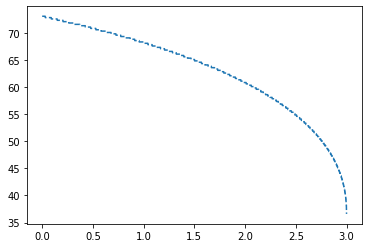

In [103]:
print('gatilho é:',gatilho[0]/(CF*q*B*np.exp(-2*delta)))
print('opcao vale:', opcao)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo,g, ls='--')


In [131]:
####Para o DogFish
start=time.time()
opcao1,PGrid1,mapa1,tempo1,preco1,gatilho1=diffinexpcart(V_cf1,Id_cf1+Iw1,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)

winsound.Beep(freq, duration)


minutos- 10.118801828225454


In [132]:
V_cf1, preco1[PGrid1]

(1723.878144200451, 1723.8781442004513)

In [133]:
preco1=preco1/(CF1*q1*B1*np.exp(-2*delta))
g1=gatilho1/(CF1*q1*B1*np.exp(-2*delta))

gatilho 1 é: 69.62500000000003
opcao 1 vale: 581.2829731756544


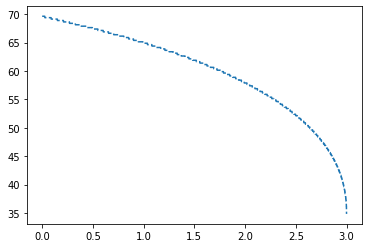

In [134]:
print('gatilho 1 é:',gatilho1[0]/(CF1*q1*B1*np.exp(-2*delta)))
print('opcao 1 vale:', opcao1)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo1,g1, ls='--')


(-5, 80)

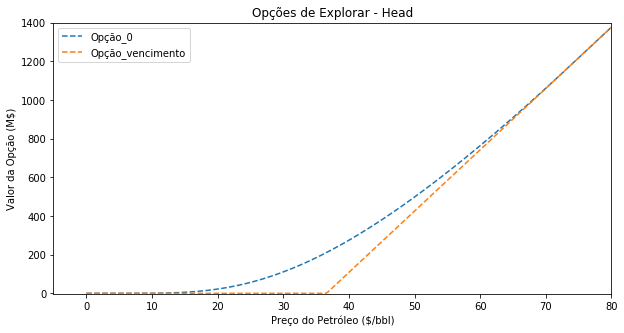

In [108]:
fig,ax=plt.subplots(figsize=(10,5))
ax.plot(preco,mapa[0,:], ls='--')

#ax.plot(preco,venc, ls='--')
ax.plot(preco,mapa[-1,:], ls='--')

plt.legend(['Opção_0','Opção_vencimento'])
ax.set_title('Opções de Explorar - Head')
ax.set_ylabel('Valor da Opção (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')

ax.set_ylim(-5,1400)
ax.set_xlim(-5,80)



In [135]:
####Para o Dog fish
V_inv1=P*q1*B1*np.exp(-2*delta)
Id_inv1=Id1*np.exp(-2*r)


In [136]:
start=time.time()
opcao_inv1,PGrid_inv1,mapa_inv1,tempo_inv1,preco_inv1,gatilho_inv1=diffinexpcart(V_inv1,Id_inv1,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 8.02643099228541


In [137]:
V_inv1, preco_inv1[PGrid_inv1]

(5746.26048066817, 5746.26048066817)

In [138]:
preco_inv1=preco_inv1/(q1*B1*np.exp(-2*delta))

In [139]:
g_inv1=gatilho_inv1/(q1*B1*np.exp(-2*delta))

gatilho de investimento 1é: 64.875
opcao de investimento 1vale: 2127.446940079004


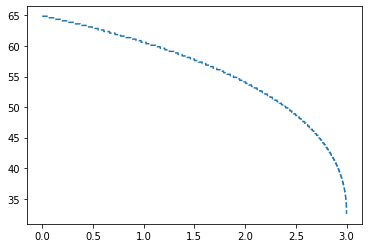

In [140]:
print('gatilho de investimento 1é:',g_inv1[0])
print('opcao de investimento 1vale:', opcao_inv1)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo_inv1,g_inv1, ls='--')


In [141]:
valor_vme1=[]
for i in range(len(preco1)):
    valor_vme1.append(carteira(CF1,q1,preco1[i],B1,delta,Id1,Iw1,r)[0])

In [142]:
VME1=CF1*opcao_inv1 -Iw1
print(VME1)
print(g_inv1[0])


558.2340820237011
64.875


In [143]:
if P>g1[0]:
    custo1=VME1*(1-np.exp(-r/12))
else:
    custo1=0

In [151]:
sinal(CF,CF1,rho)

(0.06906926585840459, 0.5055050463303894)

In [152]:
sinal(CF1,CF,rho)

(0.185435607626104, 0.758257569495584)

In [109]:

V_inv=P*q*B*np.exp(-2*delta)
Id_inv=Id*np.exp(-2*r)


In [110]:
start=time.time()
opcao_inv,PGrid_inv,mapa_inv,tempo_inv,preco_inv,gatilho_inv=diffinexpcart(V_inv,Id_inv,r,delta,sigma,tau,accur)
cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 4.233646178245545


In [111]:
V_inv, preco_inv[PGrid_inv]

(7924.2785660827185, 7924.2785660827185)

In [112]:
preco_inv=preco_inv/(q*B*np.exp(-2*delta))

In [113]:
g_inv=gatilho_inv/(q*B*np.exp(-2*delta))

gatilho é: 68.125
opcao vale: 2755.6695849420903


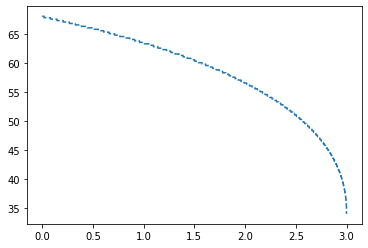

In [114]:
print('gatilho é:',g_inv[0])
print('opcao vale:', opcao_inv)
#plt.plot(tempo[:-1],g[:-1], ls='--')
plt.plot(tempo_inv,g_inv, ls='--')


In [115]:
len(preco)

785

In [116]:
valor_vme=[]
for i in range(len(preco)):
    valor_vme.append(carteira(CF,q,preco[i],B,delta,Id,Iw,r)[0])

Text(0.5, 0, 'Preço do Petróleo (\\$/bbl)')

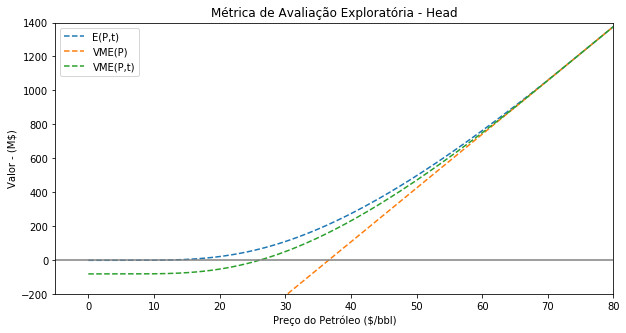

In [117]:
fig,ax=plt.subplots(figsize=(10,5))

ax.plot(preco,mapa[0,:], ls='--')
ax.plot(preco,valor_vme, ls='--')
ax.plot(preco_inv,CF*mapa_inv[0,:] - Iw, ls='--')

ax.axhline(0, linestyle='-', color='grey')



#ax.plot(preco,venc, ls='--')
#ax.plot(preco_inv/(0.1*300*np.exp(-2*delta)),mapa_inv[-1,:], ls='--')

plt.legend(['E(P,t)','VME(P)', 'VME(P,t)'])
ax.set_ylim(-200,1400)
ax.set_xlim(-5,80)
ax.set_title('Métrica de Avaliação Exploratória - Head')

ax.set_ylabel('Valor - (M\$)')
ax.set_xlabel('Preço do Petróleo (\$/bbl)')



In [118]:
VME=CF*opcao_inv -Iw
print(VME)
print(g_inv[0])

471.13391698841804
68.125


In [119]:
if P>g[0]:
    custo=VME*(1-np.exp(-r/12))
else:
    custo=0

In [153]:
start=time.time()

opcao_up,PGrid_up,mapa_up,tempo_up,preco_up,gatilho_up=diffinexpcart(sinal(CF,CF1,rho)[1]*P*q*B*np.exp(-2*delta),sinal(CF,CF1,rho)[1]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_down,PGrid_down,mapa_down,tempo_down,preco_down,gatilho_down=diffinexpcart(sinal(CF,CF1,rho)[0]*P*q*B*np.exp(-2*delta),sinal(CF,CF1,rho)[0]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_info=CF1*opcao_up + (1-CF1)*opcao_down

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 26.12833024263382


In [154]:
preco_up=preco_up/(sinal(CF,CF1,rho)[1]*q*B*np.exp(-2*delta))
preco_down=preco_down/(sinal(CF,CF1,rho)[0]*q*B*np.exp(-2*delta))

In [155]:
F_up_zero=np.interp(preco_inv,preco_up,mapa_up[0,:])
F_down_zero=np.interp(preco_inv,preco_down,mapa_down[0,:])
F_zero=CF1*F_up_zero+ (1-CF1)*F_down_zero

Exp_zero=np.interp(preco_inv,preco,mapa[0,:])

L_zero=CF*mapa_inv[0,:] - Iw


In [156]:
###############3Para o Dog Fish

In [158]:
start=time.time()

opcao_up1,PGrid_up1,mapa_up1,tempo_up1,preco_up1,gatilho_up1=diffinexpcart(sinal(CF1,CF,rho)[1]*P*q1*B1*np.exp(-2*delta),sinal(CF1,CF,rho)[1]*Id1*np.exp(-2*r)+Iw1,r,delta,sigma,tau,accur)
opcao_down1,PGrid_down1,mapa_down1,tempo_down1,preco_down1,gatilho_down1=diffinexpcart(sinal(CF1,CF,rho)[0]*P*q1*B1*np.exp(-2*delta),sinal(CF1,CF,rho)[0]*Id1*np.exp(-2*r)+Iw1,r,delta,sigma,tau,accur)
opcao_info1=CF*opcao_up1 + (1-CF)*opcao_down1

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)



minutos- 19.835141237576803


In [159]:
preco_up1=preco_up1/(sinal(CF1,CF,rho)[1]*q1*B1*np.exp(-2*delta))
preco_down1=preco_down1/(sinal(CF1,CF,rho)[0]*q1*B1*np.exp(-2*delta))

In [160]:
F_up_zero1=np.interp(preco_inv1,preco_up1,mapa_up1[0,:])
F_down_zero1=np.interp(preco_inv1,preco_down1,mapa_down1[0,:])
F_zero1=CF*F_up_zero1+ (1-CF)*F_down_zero1

Exp_zero1=np.interp(preco_inv1,preco1,mapa1[0,:])

L_zero1=CF1*mapa_inv1[0,:] - Iw1


In [166]:
F_up_zero1=np.interp(preco_inv,preco_up1,mapa_up1[0,:])
F_down_zero1=np.interp(preco_inv,preco_down1,mapa_down1[0,:])
F_zero1=CF*F_up_zero1+ (1-CF)*F_down_zero1

Exp_zero1=np.interp(preco_inv,preco1,mapa1[0,:])

L_zero1=CF1*np.interp(preco_inv,preco_inv1,mapa_inv1[0,:]) - Iw1


In [170]:
len(L_zero1), len(L_zero), len(F_zero), len(F_zero1)

(731, 731, 731, 731)

In [193]:
pa=preco_inv[F_zero-L_zero<0.01][0]
pa1=preco_inv[F_zero1-L_zero1<0.01][0]
print(pa)
print(pa1)

82.25
72.25


Hoje, o gatilho explorar DogFish é: 69.625
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo DogFish é: 72.25
Hoje, o gatilho simultaneo Head é: 82.25


[]

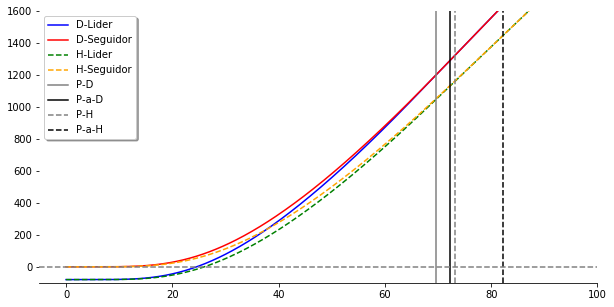

In [199]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar DogFish é:',round(g1[0],3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo DogFish é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,L_zero1, color='blue', ls='-' )
ax.plot(preco_inv,F_zero1, color='red', ls='-' )

ax.plot(preco_inv,L_zero, color='green', ls='--' )
ax.plot(preco_inv,F_zero, color='orange', ls='--' )

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=g1[0], linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D-Lider','D-Seguidor','H-Lider','H-Seguidor','P-D','P-a-D','P-H','P-a-H'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=100)
ax.set_ylim(top=1600)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [209]:
np.where(preco_inv>100)[0][0]

401

In [227]:
preco_inv[100]

25.0

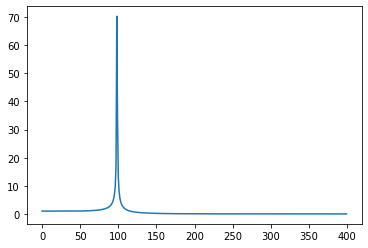

In [226]:
plt.plot(np.round(np.absolute(np.round(F_zero1,2)/np.round(L_zero1,2) -1),2)[0:400])

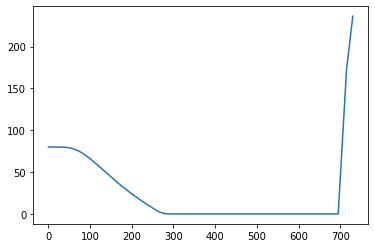

In [243]:
plt.plot(F_zero1- L_zero1)
#plt.plot(np.absolute(F_zero-L_zero)[0:400])

Hoje, o gatilho explorar DogFish é: 69.625
Hoje, o gatilho explorar Head é: 73.125
Hoje, o gatilho simultaneo DogFish é: 72.25
Hoje, o gatilho simultaneo Head é: 82.25


[]

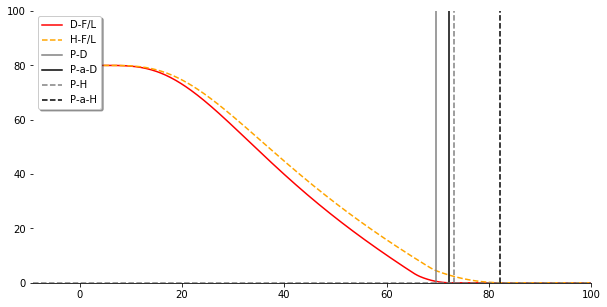

In [247]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)
print('Hoje, o gatilho explorar DogFish é:',round(g1[0],3))
print('Hoje, o gatilho explorar Head é:',round(g[0],3))
print('Hoje, o gatilho simultaneo DogFish é:',pa1)
print('Hoje, o gatilho simultaneo Head é:',pa)

ax.plot(preco_inv,F_zero1-L_zero1, color='red', ls='-' )

ax.plot(preco_inv,F_zero-L_zero, color='orange', ls='--' )

#ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axvline(x=g1[0], linestyle='-', color='grey')
ax.axvline(x=pa1, linestyle='-', color='black')


ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(x=pa, linestyle='--', color='black')


ax.axhline(0, linestyle='--', color='grey')

#ax.axvline(pa, linestyle='--', color='grey')

#ax.set_ylim(0,100)
#ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['D-F/L','H-F/L','P-D','P-a-D','P-H','P-a-H'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=100)
ax.set_ylim(top=100)
ax.set_ylim(bottom=0)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [ ]:
####Até onde vai a guerra de atrito?? P_atrito
pa=preco_inv[F_zero-L_zero<0.01][0]
print(pa)

In [606]:
start=time.time()
rho1=0.8
opcao_up_n,PGrid_up_n,mapa_up_n,tempo_up_n,preco_up_n,gatilho_up_n=diffinexpcart(sinal(CF,rho1)[1]*P*q*B*np.exp(-2*delta),sinal(CF,rho1)[1]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_down_n,PGrid_down_n,mapa_down_n,tempo_down_n,preco_down_n,gatilho_down_n=diffinexpcart(sinal(CF,rho1)[0]*P*q*B*np.exp(-2*delta),sinal(CF,rho1)[0]*Id*np.exp(-2*r)+Iw,r,delta,sigma,tau,accur)
opcao_info_n=CF*opcao_up_n + (1-CF)*opcao_down_n

cpu=time.time()-start
print('minutos-',cpu/60)
winsound.Beep(freq, duration)

minutos- 12.660146395365397


In [607]:
preco_up_n=preco_up_n/(sinal(CF,rho1)[1]*q*B*np.exp(-2*delta))
preco_down_n=preco_down_n/(sinal(CF,rho1)[0]*q*B*np.exp(-2*delta))

In [608]:
F_up_zero_n=np.interp(preco_inv,preco_up_n,mapa_up_n[0,:])
F_down_zero_n=np.interp(preco_inv,preco_down_n,mapa_down_n[0,:])
F_zero_n=CF*F_up_zero_n+ (1-CF)*F_down_zero_n


In [609]:
F_zero_n.size, L_zero.size

(697, 697)

In [610]:
######Até onde vai a guerra de atrito

preco_inv[F_zero_n-L_zero<0.01][0]


87.50000000000001

In [571]:
preco_inv[np.where(L_zero==Exp_zero)[0][0]]

69.75

In [572]:
F_zero.shape, Exp_zero.shape

((697,), (697,))

In [613]:
U_1=np.maximum(0, L_zero+ F_zero_n)

In [614]:
U_1_i=U_1*.5

In [573]:
U=np.maximum(0, L_zero+ F_zero)

In [574]:
U[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]]*.5

570.8022472080579

In [575]:
U[np.where(np.round(preco_inv,2)==np.round(72,2))[0][0]]*.5

1281.9552860747046

In [576]:
U[np.where(np.round(preco_inv,2)==np.round(80,2))[0][0]]*.5

1557.4110593021073

In [621]:
U_1[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]]*.5

572.675749215977

In [623]:
U_1[np.where(np.round(preco_inv,2)==np.round(72,2))[0][0]]*.5

1283.6464004490645

In [582]:
np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]
print(preco_inv[np.where(np.round(preco_inv,2)==np.round(P,2))[0][0]])

50.00000000000001


In [578]:
w_i=0.5

In [579]:
U_i=U*w_i

In [580]:
preco[np.where(U_i>0)[0][0]]

21.250000000000004

[]

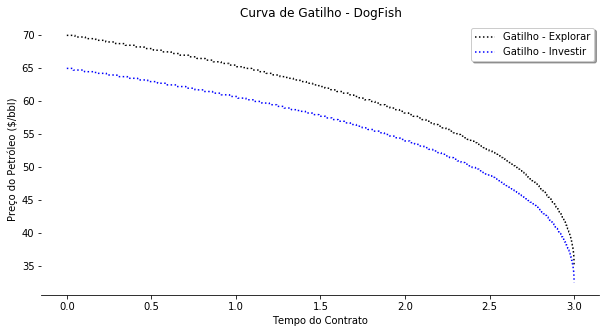

In [73]:
#####Figuras de Gatilho e a#####
fig, ax= plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

#print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
#print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))

ax.plot(tempo,g, color='black', ls=':' )
ax.plot(tempo_inv,g_inv, color='blue', ls=':' )

ax.legend(['Gatilho - Explorar','Gatilho - Investir'], loc='upper right', shadow=True)

ax.set_xlabel('Tempo do Contrato')
ax.set_ylabel('Preço do Petróleo (\$/bbl)')
#ax1.set_xticklabels([0,1000,2000,5000,10000,50000,100000])
ax.set_title('Curva de Gatilho - DogFish')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88


[]

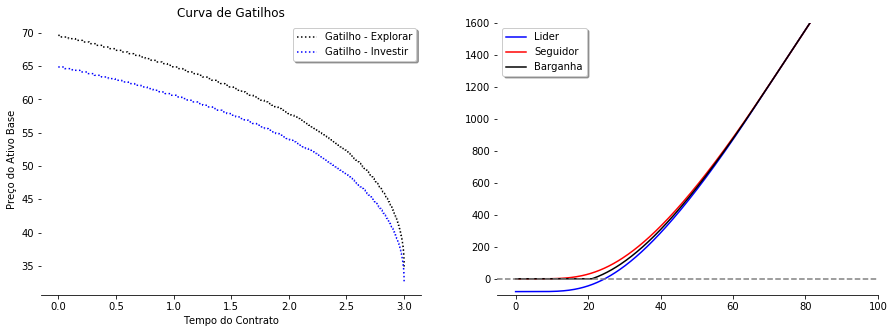

In [612]:
#####Figuras de Gatilho e a#####
fig, (ax1,ax2)= plt.subplots(1,2, figsize=(15,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))

ax1.plot(tempo,g, color='black', ls=':' )
ax1.plot(tempo_inv,g_inv, color='blue', ls=':' )

ax1.legend(['Gatilho - Explorar','Gatilho - Investir'], loc='upper right', shadow=True)

ax1.set_xlabel('Tempo do Contrato')
ax1.set_ylabel('Preço do Ativo Base')
#ax1.set_xticklabels([0,1000,2000,5000,10000,50000,100000])
ax1.set_title('Curva de Gatilhos')


ax2.plot(preco_inv,L_zero, color='blue', ls='-' )
ax2.plot(preco_inv,F_zero, color='red', ls='-' )
ax2.plot(preco_inv,U_i,color='black',ls='-')
ax2.axhline(0, linestyle='--', color='grey')

ax2.set_ylim(-20,250)
ax2.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax2.set_xlim(right=100)
ax2.set_ylim(top=1600)
ax2.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [498]:
#####Exploracao com custo
EXP_custo=[]
for i in range(len(preco_inv)):
    if preco_inv[i]>g[0]:
        c=L_zero[i]*(1-np.exp(-r/12))
    else:
        c=0
    #print(c)
    EXP_custo.append(Exp_zero[i]-c)


gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 76.25


[]

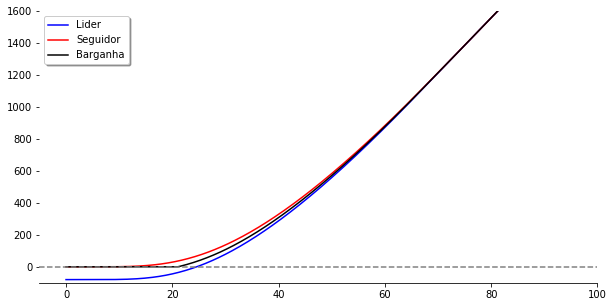

In [620]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
#ax.axvline(x=g[0], linestyle='--', color='grey')
#ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=100)
ax.set_ylim(top=1600)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 76.25


[]

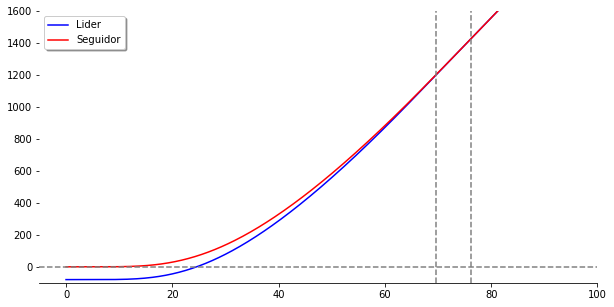

In [532]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
#ax2.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=100)
ax.set_ylim(top=1600)
ax.set_ylim(bottom=-100)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 76.25


[]

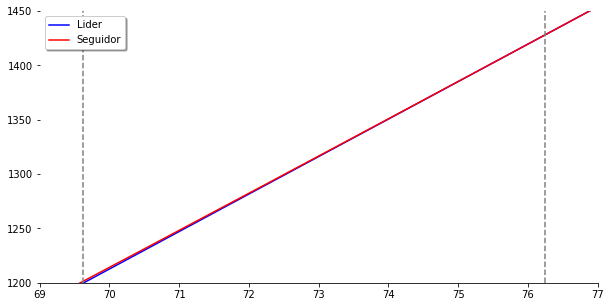

In [531]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
#ax2.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=77)
ax.set_xlim(left=69)

ax.set_ylim(top=1450)
ax.set_ylim(bottom=1200)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 76.25


[]

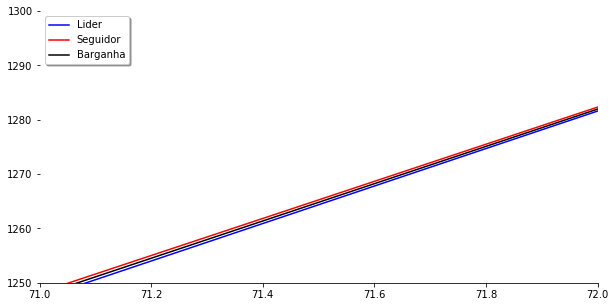

In [619]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
ax.plot(preco_inv,U_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=72)
ax.set_xlim(left=71)

ax.set_ylim(top=1300)
ax.set_ylim(bottom=1250)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

gatilho explorar hoje é: 69.63
gatilho investir hoje é: 64.88
saida do atrito - gatilho simultaneo: 76.25


[]

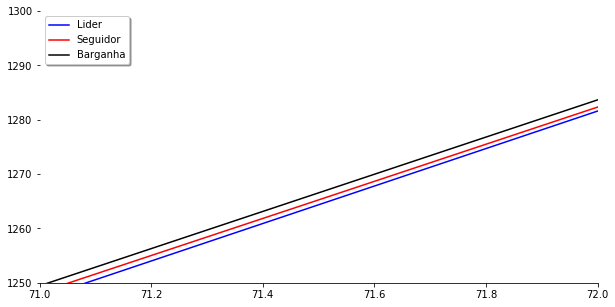

In [618]:
#####Figuras de Gatilho e a#####
fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.despine(left=True)

print('gatilho explorar hoje é:',round(gatilho[0]/(CF*q*B*np.exp(-2*delta)),2))
print('gatilho investir hoje é:',round(gatilho_inv[0]/(q*B*np.exp(-2*delta)),2))
print('saida do atrito - gatilho simultaneo:',round(pa,2))


ax.plot(preco_inv,L_zero, color='blue', ls='-' )
ax.plot(preco_inv,F_zero, color='red', ls='-' )
ax.plot(preco_inv,U_1_i,color='black',ls='-')
#ax.plot(preco_inv,EXP_custo,color='black',ls='-')

ax.axhline(0, linestyle='--', color='grey')
ax.axvline(x=g[0], linestyle='--', color='grey')
ax.axvline(pa, linestyle='--', color='grey')

ax.set_ylim(-20,250)
ax.set_xlim(-5,120)

#ax2.plot(V_vetor,F_V_Matrix[F_V_Matrix.shape[0]-1,:], color='blue', ls='--' )

#ax2.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
ax.legend(['Lider','Seguidor','Barganha'], loc='upper left', shadow=True)
#ax2.set_xlabel('Preço do Ativo Base')
#ax2.set_ylabel('Valor da Opção')
ax.set_xlim(right=72)
ax.set_xlim(left=71)

ax.set_ylim(top=1300)
ax.set_ylim(bottom=1250)
#ax2.set_title('Opção de Investir em função do Preço')

plt.plot()

In [637]:
preco_inv[(U_1_i>F_zero)] | preco_inv[(U_1_i>U_i)]

TypeError: ufunc 'bitwise_or' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

In [643]:
preco_inv[np.logical_and((U_1_i>F_zero),(U_1_i>U_i))]

array([ 66.25,  66.5 ,  66.75,  67.  ,  67.25,  67.5 ,  67.75,  68.  ,
        68.25,  68.5 ,  68.75,  69.  ,  69.25,  69.5 ,  69.75,  70.  ,
        70.25,  70.5 ,  70.75,  71.  ,  71.25,  71.5 ,  71.75,  72.  ,
        72.25,  72.5 ,  72.75,  73.  ,  73.25,  73.5 ,  73.75,  74.  ,
        74.25,  74.5 ,  74.75,  75.  ,  75.25,  75.5 ,  75.75,  76.  ,
        76.25,  76.5 ,  76.75,  77.  ,  77.25,  77.5 ,  77.75,  78.  ,
        78.25,  78.5 ,  78.75,  79.  ,  79.25,  79.5 ,  79.75,  80.  ,
        80.25,  80.5 ,  80.75,  81.  ,  81.25,  81.5 ,  81.75,  82.  ,
        82.25,  82.5 ,  82.75,  83.  ,  83.25,  83.5 ,  83.75,  84.  ,
        84.25,  84.5 ,  84.75,  85.  ,  85.25,  85.5 ,  85.75,  86.  ,
        86.25,  86.5 ,  86.75,  87.  ,  87.25,  87.5 ,  87.75,  88.  ,
        88.75,  90.75,  94.75,  97.5 ,  99.25, 101.25, 103.  , 104.  ,
       104.5 , 105.  , 107.25, 107.75, 109.75, 111.75, 113.75, 123.5 ,
       127.25, 133.  , 136.25, 139.  , 141.  , 145.  , 149.75, 165.25,
      

In [644]:
preco_inv[U_1_i>F_zero]

array([ 66.25,  66.5 ,  66.75,  67.  ,  67.25,  67.5 ,  67.75,  68.  ,
        68.25,  68.5 ,  68.75,  69.  ,  69.25,  69.5 ,  69.75,  70.  ,
        70.25,  70.5 ,  70.75,  71.  ,  71.25,  71.5 ,  71.75,  72.  ,
        72.25,  72.5 ,  72.75,  73.  ,  73.25,  73.5 ,  73.75,  74.  ,
        74.25,  74.5 ,  74.75,  75.  ,  75.25,  75.5 ,  75.75,  76.  ,
        76.25,  76.5 ,  76.75,  77.  ,  77.25,  77.5 ,  77.75,  78.  ,
        78.25,  78.5 ,  78.75,  79.  ,  79.25,  79.5 ,  79.75,  80.  ,
        80.25,  80.5 ,  80.75,  81.  ,  81.25,  81.5 ,  81.75,  82.  ,
        82.25,  82.5 ,  82.75,  83.  ,  83.25,  83.5 ,  83.75,  84.  ,
        84.25,  84.5 ,  84.75,  85.  ,  85.25,  85.5 ,  85.75,  86.  ,
        86.25,  86.5 ,  86.75,  87.  ,  87.25,  87.5 ,  87.75,  88.  ,
        88.25,  88.75,  90.75,  91.  ,  91.5 ,  93.25,  94.  ,  94.75,
        96.25,  97.5 ,  99.  ,  99.25, 100.5 , 101.  , 101.25, 103.  ,
       103.25, 103.75, 104.  , 104.5 , 105.  , 106.  , 106.5 , 107.25,
      

In [641]:
np.logical_and((U_1_i>F_zero),(U_1_i>U_i))

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [401]:
########################Guerra de Atrito##############################3

In [402]:
print(opcao)
print(opcao_info)
print(custo)
print(VME)

581.2829731756544
583.3704123924147
0
558.2340820237011


In [403]:
import nashpy as nash

In [404]:
A_matrix=[[VME, VME],[opcao_info,opcao-custo]]
A_matrix=np.round(A_matrix,2)

In [405]:
B_matrix=[[VME,opcao_info],[VME,opcao-custo]]
B_matrix=np.round(B_matrix,2)

In [406]:
war_att=nash.Game(A_matrix,B_matrix)
war_att

Bi matrix game with payoff matrices:

Row player:
[[558.23 558.23]
 [583.37 581.28]]

Column player:
[[558.23 583.37]
 [558.23 581.28]]

In [407]:
eq=list(war_att.support_enumeration())
eq

[(array([0., 1.]), array([0., 1.]))]

In [408]:
for s1,s2 in eq:
    row_util=np.dot(np.dot(s1,A_matrix),s2)
    col_util=np.dot(np.dot(s1,B_matrix),s2)
    print(row_util,col_util)

581.28 581.28


In [469]:
###P gatilho exploratorio
g[0]

69.62500000000003

In [387]:
###################################Simulações da Guerra de Atrito##############################################

In [260]:
import nashpy as nash

In [338]:
P1=50
loc=np.where(np.round(preco_inv,2)==P1)[0][0]

In [339]:
###Jogador 1 está na horizontal - DogFish
VME1=L_zero1[loc]
opcao_info1=F_zero1[loc]
opcao1=Exp_zero1[loc]



In [340]:
if P1>g1[0]:
    custo1=VME1*(1-np.exp(-r/12))
else:
    custo1=0

In [341]:
###Jogador 1 está na horizontal - Head
VME2=L_zero[loc]
opcao_info2=F_zero[loc]
opcao2=Exp_zero[loc]



In [342]:
if P1>g[0]:
    custo2=VME2*(1-np.exp(-r/12))
else:
    custo2=0

In [343]:
####Ações do Jogador 1
A_matrix=[[VME1, VME1],[opcao_info1,opcao1-custo1]]
A_matrix=np.round(A_matrix,2)

In [344]:
###Ações do Jogador 2
B_matrix=[[VME2,opcao_info2],[VME2,opcao2-custo2]]
B_matrix=np.round(B_matrix,2)
war_att=nash.Game(A_matrix,B_matrix)
war_att



Bi matrix game with payoff matrices:

Row player:
[[558.23 558.23]
 [582.19 581.28]]

Column player:
[[471.13 500.48]
 [471.13 497.72]]

In [333]:
eq=list(war_att.support_enumeration())
eq

[(array([1., 0.]), array([0., 1.])), (array([0., 1.]), array([1., 0.]))]

In [334]:
for s1,s2 in eq:
    row_util=np.dot(np.dot(s1,A_matrix),s2)
    col_util=np.dot(np.dot(s1,B_matrix),s2)
    print(row_util,col_util)

1626.37 1439.45
1626.37 1439.43


In [335]:
len(eq[0])

2

In [336]:
suporte=[[1,2],[3,4]]

In [388]:

matrix=np.zeros((len(preco_inv),6))
for loc in range(len(preco_inv)):    
    #P1=50
    #loc=np.where(np.round(preco_inv,2)==P1)[0][0]
    #print(preco_inv[loc])
    
    VME1=L_zero1[loc]
    opcao_info1=F_zero1[loc]
    opcao1=Exp_zero1[loc]
    
    if preco_inv[loc]>g1[0]:
        custo1=VME1*(1-np.exp(-r/12))
    else:
        custo1=0
        
    ###Jogador 1 está na horizontal - Head
    VME2=L_zero[loc]
    opcao_info2=F_zero[loc]
    opcao2=Exp_zero[loc]

    if preco_inv[loc]>g[0]:
        custo2=VME2*(1-np.exp(-r/12))
    else:
        custo2=0
        

    #Ações do jogador 1
    A_matrix=[[VME1, VME1],[opcao_info1,opcao1-custo1]]
    A_matrix=np.round(A_matrix,2)


    ###Ações do Jogador 2
    B_matrix=[[VME2,opcao_info2],[VME2,opcao2-custo2]]
    B_matrix=np.round(B_matrix,2)
    war_att=nash.Game(A_matrix,B_matrix)

    eq=list(war_att.support_enumeration())
    #print(eq)


    suporte=[[1,2],[3,4]]
    
    matrix[loc,0]=preco_inv[loc]
    i=1
    for s1,s2 in eq:
        quadrante=np.dot(np.dot(s1,suporte),s2)
        #print(i)
        matrix[loc,i]=quadrante
        i=i+1
        

In [389]:
df=pd.DataFrame(matrix)

In [390]:
df.head()

,0,1,2,3,4,5
0,0.00,4.0,0.0,0.0,0.0,0.0
1,0.25,4.0,0.0,0.0,0.0,0.0
2,0.50,4.0,0.0,0.0,0.0,0.0
3,0.75,4.0,0.0,0.0,0.0,0.0
4,1.00,4.0,0.0,0.0,0.0,0.0


In [391]:
df=df.set_index(0)

In [392]:
df[df==0]=np.nan

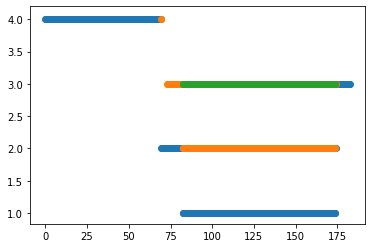

In [404]:
plt.scatter(df.index, df.iloc[:,0])
plt.scatter(df.index, df.iloc[:,1])
plt.scatter(df.index, df.iloc[:,2])
#plt.scatter(df.index, df.iloc[:,3])
#plt.scatter(df.index, df.iloc[:,4])


In [189]:
# bjst(V,I,r,div,sigma,tau):
#valor da opção
bjst(V_cf,Iw+Id_cf,r,delta,sigma,3)

[270.6377358848911, 2115.5971940119207, 1292.9086081503383]

In [132]:
vcritico(Iw+Id_cf,r,delta,sigma,tau+2)[1]/(CF*q*B*np.exp(-2*delta))

69.55766396918423

In [64]:

(CF*q*B*np.exp(-2*delta))

array([[16.99424099, 15.91862444],
       [16.93376623, 15.91862444]])

In [125]:
# bjst(V,I,r,div,sigma,tau):
#valor da opção
bjst(V,Iw+Id,r,delta,sigma,2)[1]/(0.2*0.1*300*np.exp(-2*delta))

NameError: name 'V' is not defined

In [30]:
opcao - bjst(V,Iw+Id,r,delta,sigma,2)[0]

NameError: name 'opcao' is not defined

In [56]:
opcao

407.4722171680524